In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import numpy as np
from vortexpanel import VortexPanel as vp
from vortexpanel import BoundaryLayer as bl

# Coefficient of Lift $C_L$

To compute the pressure, $P$, we can use the Bernoulli equation

$$ P+\frac {1}{2} \rho\ |u|^2-\rho gz = B $$

where $\rho$ is the density, $\rho gz$ is the head, and $B$ is the Bernoulli coefficient. As in the rest of this course, will assume no hydrostatic pressure.

To avoid the ambiguity of the Bernoulli coefficient, we typically work with the pressure coefficient $c_p$

$$c_p = \frac{P-P_\infty}{\frac{1}{2} \rho U^2}$$
instead of the pressure.

Once we have the surface pressure we can use it to determine the pressure force on the body, as

$$ \vec F_p = -\oint p \hat n da $$

where $\oint da$ is the integral over the body surface, and $\hat n$ is the normal vector to the surface. 

For instance, the lift coefficient is then:

$$ C_L = \frac{\vec F_p \cdot \hat U_\perp} { \tfrac 12 \rho U^2 A }  = \frac{-\oint p \hat n \cdot \hat U_\perp ds }{ \tfrac 12 \rho U^2 c } c= -\frac{\oint c_p (s_x\cos\alpha+s_y\sin\alpha) ds}{ c } $$

where $c$ is the coord, $\hat U_\perp=\cos\alpha\hat y-\sin\alpha\hat x$ is the direction perpendicular to the free stream and $\hat n=s_x\hat y-s_y\hat x$.

And we can use $|u/U|^2=\tilde\gamma^2=\gamma^2$ on the body of $N$ panels to give

$$ C_L = \Sigma_N [(1-\gamma^2) S_N \hat n_N] / c $$


In [3]:
@np.vectorize
def C_L(panels,alpha):
    """ Calculate the coefficient of lift for a solved Panel Array

    Inputs:
    panels    -- a solved Panel Array
    alpha     -- the angle of attack

    Outputs:
    The coefficient of lift

    Example:
    alpha=np.radians(10)                                # set the angle of attack
    ellipse = vp.make_ellipse(N=32,t_c=0.5)             # make a 1:2 elliptical Panel array
    ellipse.solve_gamma_O2(alpha=alpha)                 # solve the ellipse flow using a second order panel array method
    print(C_L(ellipse, alpha=alpha))                    # print the coefficient of lift
    """
    panels.solve_gamma_O2(alpha, kutta=[(0,-1)])
    gamma, xc, S, sx, sy = panels.get_array('gamma','xc','S','sx','sy') # use the solved flow to retrieve gamma, xc, S, sx, sy
    c = max(xc)-min(xc)                                                 # calculate the length of the foil chord
    perp = sx*np.cos(alpha)+sy*np.sin(alpha)                            # calculate the normal 
    return -sum((1-gamma**2)*2*S*perp)/c                                # return the coefficient of lift (summation of c_p x normal over the surface)

## Validation of $C_L$ function

There exists an analytical solution for $C_L$ of a Joukowski foil

$$C_L = 2\pi \left(1+\frac {4}{3\sqrt 3} \frac {t}{c} \right)\sin\alpha$$

where $t/c$ is the thickness to coord ratio.

Writing this into a simple function for testing





In [4]:
def analytic_C_L(alpha,t_c=0.2355): # t/c of jfoil xcen=-0.1
    """ Calculate the analytic coefficient of lift for a Joukowski foil

    Inputs:
    alpha     -- the angle of attack
    t_c       -- the thickness of the foil as a fraction of chord

    Outputs:
    The analytic coefficient of lift

    Example:
    print(analytic_C_L(alpha=0.1, t_c=0.2355))
    """
    return 2*np.pi*(1+t_c*4/(3*np.sqrt(3)))*np.sin(alpha)

Testing this on a Joukowski foil with centre (-0.1, 0) and thus $t/c = 0.2355$ leads to:

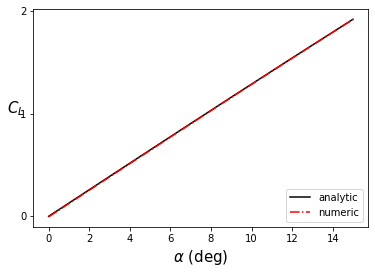

In [5]:
alpha_deg = np.linspace(0,15,6)
alpha = alpha_deg*np.pi/180.
plt.plot(alpha_deg,analytic_C_L(alpha), 'k', label='analytic')

jfoil = vp.make_jfoil(N=64, xcen=-0.1, ycen=0)
plt.plot(alpha_deg, C_L(jfoil, alpha), 'r-.', label='numeric')

plt.legend(loc='lower right')
plt.xlabel(r'$\alpha$ (deg)', fontsize=15)
plt.ylabel(r'$C_L$', fontsize=15, rotation=0)
plt.yticks([0,1,2]);

It can be seen from the above plot that there is no noticable difference between the analytical and numerical solution

# Coefficient of Drag $C_D$

Because potential flow has no pressure drag. D'Alemberts paradox states that any 'closed' flow can't give any pressure drag. Therefore we must define a wake model to measure drag

## Assumptions

* The boundary layers separate from the body into a pair of **shear layers**, 
* The shear layers maintain the same strength ($\gamma$) as they were at the point of separation. 
* The distance between the shear layers ($w$) stays the same.

The vortex impulse drag for this model is:

$$D_P = \rho \frac{d}{dt} \int_S y \gamma ds$$

given the above assumptions we have

$$ y = \pm \frac{w}{2} \text{ and } \gamma = \pm\gamma_{wake} $$

Since the wake sheets are formed from the sperating of boundary layers, the wake strength should match the potential flow solution at the point of separation

$$ \gamma_{wake} \approx u_e|_{sep} $$

and by the same argument, 

$$ \frac{d}{dt}S \text{~} u_e|_{sep} \approx \gamma_{wake}$$

since $y = +/- 0.5w$ and $ds/dt \approx \gamma$, we have

$$D_P \tilde{} \rho \gamma^2 A_w$$

where $A_w = wh$ is the wake width

$$C_D = \frac{D}{0.5 \rho U^2 A_F} \propto \frac{A_w \gamma^2}{A_F U^2} \equiv A_\gamma$$

Therefore we define a wake drag coefficient as:

$$C_\gamma = \frac{wb}{A_F} \tilde{u}^2_e|_{sep} = \frac {\rho \gamma^2 w}{\rho U^2 t} = \frac w t \tilde\gamma ^2 \propto C_P$$ 

Since the wake coefficient $C_\gamma$ only scales like the drag coeffient $C_D$ we must calibrate our wake drag coefficient $C_\gamma$ to scale with $C_D$ using empirical data from Hoerner for an ellipse at 0 angle of attack:

```
c_t = [1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15]
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]
```

where `c_t` is the $c/t$ value of the ellipse, and `CD` is the $C_D$ value measure in the experiments



In [6]:
def C_gamma(panels):
    """ Calculate the wake coefficient for a solved Panel Array

    Inputs:
    panels    -- a solved Panel Array

    Outputs:
    The wake coefficient

    Example:
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    print(C_gamma(panels))              # print the value of C_gamma
    """
    top,bot=panels.split()                              # split the panels at the stagnation point
    _,_,iSep = top.thwaites()                           # locate the separation point along the top of the shape
    gamma_top = bl.sep(top.get_array('gamma'),iSep)     # get the value of gamma at the separation point
    w_top = bl.sep(top.get_array('yc'),iSep)            # get the y-value (measured perpendicularly from the chord) at the separation point (w)
    y = panels.get_array('yc')                          # get the y-values of the panel array
    thickness = max(y)-min(y)                           # calculate the height of the shape (t)
    return (2*w_top*gamma_top**2)/thickness             # calcualte the wake coefficient

Calibrating the function using `numpy.polyfit` and `numpy.poly1D` to fit a first-order line through the points, forcing an point at the origin since $C_\gamma \propto C_D$ we know that when $C_D = 0$, $C_\gamma$ will also equal $0$:

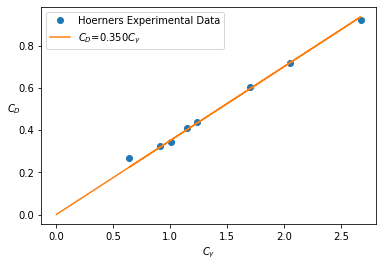

In [7]:
# Hoerner's data
c_t = np.array([1.27,1.67,2.06,3.06,3.39,4.03,4.73,8.15])
CD = [0.919,0.718,0.604,0.438,0.408,0.342,0.324,0.267]

@np.vectorize
def ellipse_c_gamma(t_c, N=64):
    """ Calculate the wake coefficient for an ellipse aligned with the flow (alpha=0)

    Inputs:
    t_c    -- the ellipse thickness/chord value
    N      -- the number of panels to create the ellipse with

    Outputs:
    The wake coefficient

    Example:
    print(ellipse_c_gamma(0.5, N=64))
    """
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    return C_gamma(panels)              # return the value of C_gamma

plt.plot(ellipse_c_gamma(1/c_t), CD, 'o', label=r'Hoerners Experimental Data')  # plot the wake ceofficient against the experimental data

x = np.append(np.array([0]), ellipse_c_gamma(1/c_t), axis=0)    # setup the data with a point at the origin
y = np.append(np.array([0]), CD, axis=0)
weights= np.append(np.array([10**10]), np.ones_like(CD))        # weight the point at the origin high to force the regression through that point
best_fit=np.polyfit(x, y, 1, w=weights)                         # regress the weighted data
plt.plot(x, np.poly1d(best_fit)(x), label=r'$C_D$={:.3f}$C_\gamma$'.format(best_fit[0]))    # plot the data

plt.xlabel(r'$C_\gamma$')
plt.ylabel(r'$C_D$', rotation=0)
plt.legend()
plt.show();

In [8]:
def C_D(panels, coeff=0.350):
    """ Calculate the drag coefficient for a solved panel array

    Inputs:
    panels    -- a solved panel array
    coeff     -- the first order coefficient relating C_gamma to C_D

    Outputs:
    The drag coefficient

    Example:
    panels = vp.make_ellipse(N, t_c)    # create a PanelArray object for an ellipse
    panels.solve_gamma_O2()             # solve the flow
    print(C_D(panels))                  # print the value of C_gamma
    """
    wake_drag = C_gamma(panels)
    return coeff*wake_drag

# Added mass coefficients $m_{11}$, $m_{12}, m_{22}, m_{66}$

The force on a body in an ideal fluid is:

$$ \vec{F} = - \oint P \hat{n} ds $$

For 1D linear motion, the scale potential into the unsteady Bernoulli equation gives the pressure in a flow as

$$ P = P_\infty - \rho a_x \tilde{\phi}_x - \frac{1}{2} \rho U_x^2 |\nabla \tilde{\phi}_x |^2 $$

where $a_x = \frac{dU_x}{dt}$ is the bodys acceleration. Substuting into the first equation gives:

$$ \vec{F} = a_{x} \rho\oint \tilde{\phi} \hat{n} dx + \frac{1}{2} \rho U^2 \oint |\nabla \tilde{\phi}|^2 ds $$

where the first expression in the equation

$$ a_{xx} P_c \oint \tilde{\phi} \hat{n} dx $$

is the additional force $F_a$ due to added mass and the latter is the lift and drag forces.

The work done on a fluid is

$$ dW = -F_x dx $$

where $F_x$ is the reaction force of the fluid on the body. Expressing this in terms of the fluid energy $E$

$$ \frac{dE}{dt} = \frac{dW}{dt} = -F_x U_x $$

so that

$$ E = \rho U_x^2 \int_V \tilde{\kappa} dv = \frac{1}{2} m_{xx} U_x^2 $$

where $\kappa = \frac{1}{2} (u^2 + v^2)$, the local kinetic energy of the flow per unit mass. This allows for the generation of a formula for $m_{xx}$

$$ m_{xx} = \rho \int_V \frac{u^2 + v^2}{U_x^2} dv = \rho \int_S |\nabla \tilde{\phi_x}^2| dv $$

In a generic case, the added mass tensor is defined as

$$ m_{ji} = \rho \int \int_S \phi_i \frac{\partial \phi_j}{\partial n} dS \text{ for } i,j = 1,2,...,6 $$

For a 2D case, $i,j = 1, 2, 6$ where indices 1 and 2 correspond to linear motions in the $x, y$ directions and indice $6$ corresponds to rotation about the z-axis

Green's theorem can be used to confirm that the added mass is symettrical, $m_{ij} = m_{ji}$. Applying Green's theorem to potentials $\phi_i$ and $\phi_j$ over a closed surface $S_B + S_C$ shows that the contribution from the external surface $S_C$ will vanish as $r \rightarrow \infty$. Therefore

$$ {\int \int}_{S_B} (\phi_i \frac{\partial \phi_j}{\partial n} - \phi_j \frac{\partial \phi_i}{\partial n})dS = 0 $$

and as such

$$ m_{ij} = m_{ji} $$

We can define

$$ \frac{ \tilde{\phi_x} }{\partial n} = \hat{x} \cdot \hat{n} = n_x $$

and similarly for y.

Given that 

$$ u = \frac{\partial \phi}{\partial x} \text{ and } v = \frac{\partial \phi}{\partial y} $$


-0.9970400926424073
Anayltical solution: m11 = 3.142, m22 = 3.142, m66 = 0.000
Numerical  solution: m11 = 2.227, m22 = 2.238, m66 = 0.000
Error (%):           m11 = -29.1, m22 = -28.8, m66 = inf


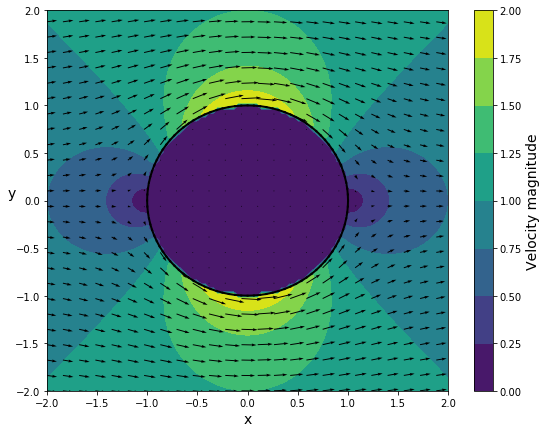

In [164]:
def added_mass(panels):
    xc, yc, S, sx, sy = panels.get_array('xc','yc','S','sx','sy') # Retrieve gamma, xc, S, sx, sy
    N = len(panels.panels)  # Get number of panels used
    A = np.zeros((N, N))    # For storage of the values from the lhs of the equation
    B11 = np.zeros(N)       # Arrays for storage of values for  the rhs of the equation
    B22 = np.zeros(N)
    B66 = np.zeros(N)

    x = np.zeros(N+1)       # set up arrays for storage of the end point coordinates
    y = np.zeros(N+1)

    for i in range(len(xc)):
        x[i] = xc[i] - 2 * S[i] * sx[i]
        y[i] = yc[i] - 2 * S[i] * sy[i]
   
    # x[0] = xc[0] - 2 * S[0] * sx[0]
    # y[0] = yc[0] - 2 * S[0] * sy[0]

    # for i in range(len(xc)):
    #     x[i+1] = xc[i] + 2 * S[i] * sx[i]
    #     y[i+1] = yc[i] + 2 * S[i] * sy[i]

    dS = 2*S                # length of panel
    n1 = -sy                # normal in the x direction
    n2 = sx                 # normal in the y direction
    n6 = xc * n2 -yc * n1   # from cross product

    for i in range(N):
        r1 = np.linalg.norm(np.array([x[:-1], y[:-1]]).T - np.array([xc[i], yc[i]]), axis=1)
        r2 = np.linalg.norm(np.array([x[1:], y[1:]]).T - np.array([xc[i], yc[i]]), axis=1)

        theta = -np.arccos( (dS**2 - r2**2 - r1**2)/(-2*r2*r1) )
        theta[np.isnan(theta)] = 0

        h11 = (np.log(r1) + np.log(r2))*0.5*dS
        h22 = (np.log(r1) + np.log(r2))*0.5*dS
        h66 = (np.log(r1) + np.log(r2))*0.5*dS

        A[i] = theta
        np.fill_diagonal(A, -np.pi)

        B11[i] = sum(n1*h11)
        B22[i] = sum(n2*h22)
        B66[i] = sum(n6*h66)

    phi11 = np.linalg.solve(A, B11)
    phi22 = np.linalg.solve(A, B22)
    phi66 = np.linalg.solve(A, B66)

    m11 = sum(phi11*n1*dS)
    m22 = sum(phi22*n2*dS)
    m66 = sum(phi66*n6*dS)

    return m11, m22, m66

def ellipse_added_mass(t_c):
    ellipse = vp.make_ellipse(100, t_c)
    ellipse.solve_gamma_O2()
    ellipse.plot_flow()

    m11_exact = np.pi*t_c**2
    m22_exact = np.pi
    m66_exact = 1/8 * np.pi * (1 - t_c**2)**2
    
    m11, m22, m66 = added_mass(ellipse)

    errors = np.array([m11/m11_exact-1, m22/m22_exact-1, m66/m66_exact-1])*100
    return m11_exact, m22_exact, m66_exact, m11, m22, m66, errors

m11_exact, m22_exact, m66_exact, m11, m22, m66, errors = ellipse_added_mass(1)

print('Anayltical solution: m11 = {:.3f}, m22 = {:.3f}, m66 = {:.3f}'.format(m11_exact, m22_exact, m66_exact))
print('Numerical  solution: m11 = {:.3f}, m22 = {:.3f}, m66 = {:.3f}'.format(m11, m22, m66))
print('Error (%):           m11 = {:.1f}, m22 = {:.1f}, m66 = {:.1f}'.format(errors[0], errors[1], errors[2]))

Anayltical solution: m11 = 0.031, m22 = 3.142, m66 = 0.385
Numerical  solution: m11 = 0.031, m22 = 3.094, m66 = 0.378
Error (%):           m11 = -0.2, m22 = -1.5, m66 = -1.7


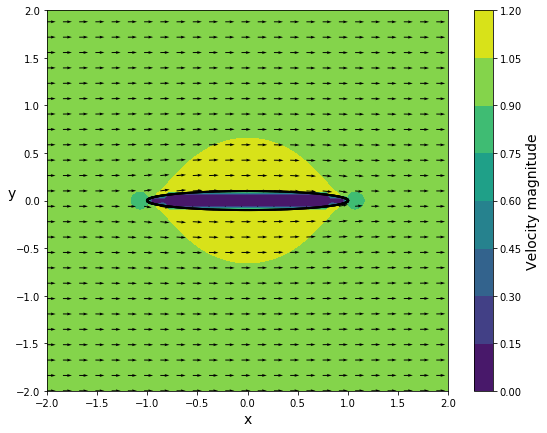

In [177]:
def ellipse_corners(N,t_c):
    theta = np.linspace(2*np.pi, 0, N+1)
    xs = np.cos(theta)
    ys = t_c*np.sin(theta)
    return xs, ys

def added_mass(x, y, panels):
    xc, yc, S, sx, sy = panels.get_array('xc','yc','S','sx','sy') # Retrieve gamma, xc, S, sx, sy
    N = len(x)-1  # Get number of panels used
    A = np.zeros((N, N))    # For storage of the values from the lhs of the equation
    B11 = np.zeros(N)       # Arrays for storage of values for  the rhs of the equation
    B22 = np.zeros(N)
    B66 = np.zeros(N)

    dS = 2*S                # length of panel
    n1 = -sy                # normal in the x direction
    n2 = sx                 # normal in the y direction
    n6 = xc * n2 -yc * n1   # from cross product

    for i in range(N):
        r1 = np.linalg.norm(np.array([x[:-1], y[:-1]]).T - np.array([xc[i], yc[i]]), axis=1)
        r2 = np.linalg.norm(np.array([x[1:], y[1:]]).T - np.array([xc[i], yc[i]]), axis=1)

        theta = -np.arccos( (dS**2 - r2**2 - r1**2)/(-2*r2*r1) )
        theta[np.isnan(theta)] = 0

        h11 = (np.log(r1) + np.log(r2))*0.5*dS
        h22 = (np.log(r1) + np.log(r2))*0.5*dS
        h66 = (np.log(r1) + np.log(r2))*0.5*dS

        A[i] = theta
        np.fill_diagonal(A, -np.pi)

        B11[i] = sum(n1*h11)
        B22[i] = sum(n2*h22)
        B66[i] = sum(n6*h66)

    phi11 = np.linalg.solve(A, B11)
    phi22 = np.linalg.solve(A, B22)
    phi66 = np.linalg.solve(A, B66)

    m11 = sum(phi11*n1*dS)
    m22 = sum(phi22*n2*dS)
    m66 = sum(phi66*n6*dS)

    return m11, m22, m66

def ellipse_added_mass(t_c):
    N=500 
    xs,ys=ellipse_corners(N,t_c)

    ellipse = vp.panelize(xs,ys) #greating panels from array of points
    ellipse.solve_gamma_O2(alpha=0.0) #solving for vorticity strength
    ellipse.plot_flow(size=2) #plotting for visual check

    m11_exact = np.pi*t_c**2
    m22_exact = np.pi
    m66_exact = 1/8 * np.pi * (1 - t_c**2)**2
    
    m11, m22, m66 = added_mass(xs, ys, ellipse)

    m11_error = (m11/m11_exact-1)*100
    m22_error = (m22/m22_exact-1)*100
    m66_error = (m66/m66_exact-1)*100

    return m11_exact, m22_exact, m66_exact, m11, m22, m66, m11_error, m22_error, m66_error

m11_exact, m22_exact, m66_exact, m11, m22, m66, m11_error, m22_error, m66_error = ellipse_added_mass(0.1)

print('Anayltical solution: m11 = {:.3f}, m22 = {:.3f}, m66 = {:.3f}'.format(m11_exact, m22_exact, m66_exact))
print('Numerical  solution: m11 = {:.3f}, m22 = {:.3f}, m66 = {:.3f}'.format(m11, m22, m66))
print('Error (%):           m11 = {:.1f}, m22 = {:.1f}, m66 = {:.1f}'.format(m11_error, m22_error, m66_error))

For a body in uniform flow

$$ \Phi = Ux + \phi $$

where $\phi$ is the disturbance potential (departure from free-stream conditions)

If the body surface is made from vortices, each with potential

$$ \phi = \frac{\Gamma}{2 \pi} \theta $$

Then the velocity potential at $P$, due to vortices on an element, $ds_Q$, of an arc centered at $Q$ is given body

$$ \phi_{PQ} = \frac{\Gamma}{2 \pi} \theta_{PQ} ds_Q $$

Where $\theta_{PQ}$ is the angle from $P$ to $Q$. Using flow superposition therefore gives

$$ \phi(x_i, y_i) = U_\infty (x_i \text{cos}(\alpha) + y_i \text{sin}(\alpha)) - \sum_{j=1}^{N} \int \frac{\Gamma}{2 \pi} \text{tan}^{-1} (\frac{y_i - y_j}{x_i - x_j}) ds_j $$



In [116]:
N_list = [100, 200, 400] # Number of segments								 

#N_list = [100, 200, 300] # Number of segments	

def Ellipse_Circle(a,b,N):
	"""
	Function for calculating the potential and added mass coefficients 
	for an ellipse where a is the half major axis and b is the half 
	minor axis. When a=b we have a circle.
	"""
	print()

	if a==b:
		print('For a circle with radius R0 = %.2f' % a)
		print()

	elif a>b:
		print('For an ellipse with half major axis a0 = %.2f' '\n'
				'and half minor axis b0 = %.2f' % (a, b))
		print()

	else:
		raise exceptions.AssertionError('The major axis a must be larger than the minor axis b')
		# As required in the text for the assignment

	# Values for the potential and the added mass coefficients. achieved from 
	# different choice of N that needs to be stored in lists for later use
	phi11_ = []
	Exact_phi_ = []
	m11_ = []
	m22_ = []
	m66_ = []

	for N in N_list:
		print ('With %d segments we have:' % N)

		# Matrix for storing values achieved from the lhs of the equation
		A = np.zeros((N,N))  

		# Array(vector) for storing values for the rhs of the equation 
		B11 = np.zeros(N)                                          
		B22 = np.zeros(N)											
		B66 = np.zeros(N)	

		dtheta = np.linspace(0, 2*np.pi, N+1) # division into N segments
		# Evaluation points
		x = a*np.cos(dtheta) # the x position of the start/end point of a segment
		y = b*np.sin(dtheta) # the y position of the start/end point of a segment

		# Collocation points
		# Centroid of each segment S(i)
		xbar = (x[1:] + x[:-1])/2.0
		ybar = (y[1:] + y[:-1])/2.0

		# Length of each segment dS = sqrt(d(x0,y0)^2 - d(x1,y1)^2)
		# (x,y) position - next (x,y) position
		dS = np.linalg.norm(np.array([x[1:],y[1:]])-np.array([x[:-1],y[:-1]]), axis=0) 

		# Normal vector components of the segments
		n1 = -(y[1:] - y[:-1])/dS 	# -dy/dS				       	 		 
		
		n2 = (x[1:] - x[:-1])/dS	# dx/dS	

		n6 = (xbar*n2 - ybar*n1) 	# x*n2 - y*n1

		for i in range(N):
			# Array transpose to get [x,y] position of a point on the circumference
			r1 = np.linalg.norm(np.array([x[:-1],y[:-1]]).T - np.array([xbar[i], ybar[i]]), axis=1)

			r2 = np.linalg.norm(np.array([x[1:],y[1:]]).T - np.array([xbar[i], ybar[i]]), axis=1)

			# Opening angle of segment S(i)
			theta = -np.arccos((dS**2 - r2**2 - r1**2)/(-2*r2*r1)) 
			theta[np.isnan(theta)] = 0	

			#Calculates the right-hand side of the integral eq.(24)
			h11 = (np.log(r1)+np.log(r2))*0.5*dS             
			h22 = (np.log(r1)+np.log(r2))*0.5*dS		     
			h66 = (np.log(r1)+np.log(r2))*0.5*dS

			#Adds the angles to the matrix A	    
			A[i] = theta # N matrices that are NxN
			np.fill_diagonal(A,-np.pi) #replace diagonal entries with -pi

			#Adds rhs to the B-arrays					    
			B11[i] = sum(n1*h11) 										 
			B22[i] = sum(n2*h22) 								 
			B66[i] = sum(n6*h66) 

		# Calculates phi for the three directions
		# Solve the linear matrix equation A*phi=B
		phi11 = np.linalg.solve(A,B11)
		phi11_.append(phi11)	

		phi22 = np.linalg.solve(A,B22)								 
		phi66 = np.linalg.solve(A,B66)

		# Calculates the added mass coefficients
		m11 = sum(phi11*n1*dS)
		m11_.append(m11)
		
		m22 = sum(phi22*n2*dS)
		m22_.append(m22)

		m66 = sum(phi66*n6*dS)
		m66_.append(m66)	

		if a>b:
			Exact_m11 = np.pi*b**2
			Error_m11 = Exact_m11-m11
			plt.plot(N, Error_m11,'r*', markersize=6, label='m_{11}')
			print('The error in the added mass coefficient m11 is %.5f' % Error_m11)

			Exact_m22 = np.pi*a**2
			Error_m22 = Exact_m22-m22
			plt.plot(N, Error_m22, 'k^', markersize=6, label='m_{22}' )
			print('The error in the added mass coefficient m22 is %.5f' % Error_m22)

			Exact_m66 = (1.0/8.0)*np.pi*((a**2) - (b**2))**2
			Error_m66 = Exact_m66-m66
			plt.plot(N, Error_m66,'gs', markersize=6, label='m_{66}')
			print('The error in the added mass coefficient m66 is %.5f' % Error_m66)
			print

		if a==b:
			Exact_phi = -(a**2*xbar)/(xbar**2 + ybar**2)
			Exact_phi_.append(Exact_phi)
			Error_phi = abs(Exact_phi-phi11).max()
			print('The maximum error between the exact and the numerical potential is %.5f' % Error_phi)
			
			Exact_m11 = np.pi*a**2
			Error_m11 = Exact_m11-m11
			print('The maximum error between the exact and the numerical added mass coefficient m11 is %.5f' % Error_m11)
			print
		if N == 20:
			legend(loc='best', numpoints = 1)
	plt.title('Error as a function of the resolution')
	plt.xlabel('Number of segments N')
	plt.ylabel('Error in the computed values compared to the exact ones')
	plt.xlim((0, 1600))
	plt.ylim((-10, 600))
	plt.show()

	return m11_, m22_, m66_, Exact_m11, Exact_m22, Exact_m66 	# in case of an ellipse
	#return phi11_, Exact_phi_, m11_, Exact_m11 		# in case of a circle



For an ellipse with half major axis a0 = 10.00
and half minor axis b0 = 1.00

With 100 segments we have:
The error in the added mass coefficient m11 is 0.02544
The error in the added mass coefficient m22 is 23.62821
The error in the added mass coefficient m66 is 328.78271
With 200 segments we have:
The error in the added mass coefficient m11 is 0.01235
The error in the added mass coefficient m22 is 11.89113
The error in the added mass coefficient m66 is 162.94352
With 400 segments we have:
The error in the added mass coefficient m11 is 0.00608
The error in the added mass coefficient m22 is 5.96638
The error in the added mass coefficient m66 is 81.09127


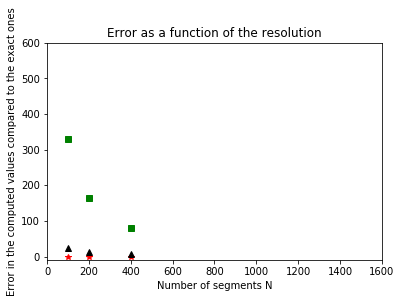

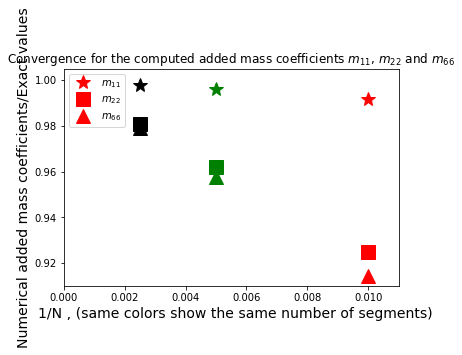

In [117]:
colors = ['r', 'g', 'k', 'c']

m11_, m22_, m66_, Exact_m11, Exact_m22, Exact_m66 = Ellipse_Circle(10, 1, N_list)


#checking for convergence
for i in range(len(N_list)):
    plt.plot(1.0/N_list[i], m11_[i]/Exact_m11,'*', color=colors[i], markersize=14, label='$m_{11}$')
    plt.plot(1.0/N_list[i], m22_[i]/Exact_m22,'s', color=colors[i], markersize=14, label='$m_{22}$')
    plt.plot(1.0/N_list[i], m66_[i]/Exact_m66,'^', color=colors[i], markersize=14, label='$m_{66}$')
    if i==0:
        plt.legend(loc='best', numpoints = 1)

plt.title('Convergence for the computed added mass coefficients ' '$m_{11}$' ', $m_{22}$' ' and ' '$m_{66}$')
plt.xlim((0, 0.011))
plt.ylim((0.91 , 1.005))
plt.ylabel('Numerical added mass coefficients/Exact values', fontsize=14)
plt.xlabel('  1/N , (same colors show the same number of segments)', fontsize=14)
plt.show()


calculated added mass:  0.19265094453636689

actual added mass: 3.141592653589793

error:  93.86772997714293 %


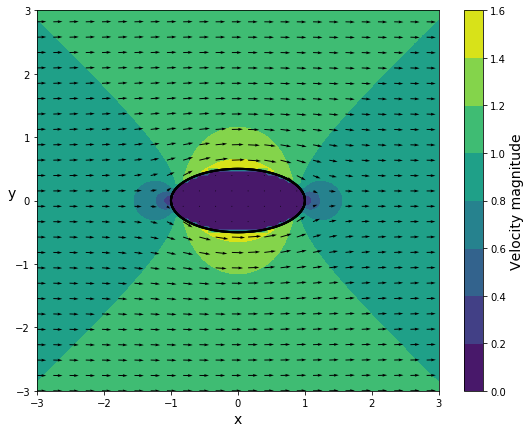

In [162]:
@np.vectorize
def make_ellipse(N,a,b):
    panels = np.linspace(2*np.pi, 0, N+1)
    xs = a*np.cos(panels)
    ys = b*np.sin(panels)
    return xs, ys

def added_mass():
    a=1 # half vertical height (radius of a circle)
    b=0.5 # half horizontal length
    N=500 #number of points in geometery
    xs,ys=make_ellipse(N,a,b)

    my_panels = vp.panelize(xs,ys) #greating panels from array of points
    my_panels.solve_gamma_O2(alpha=0.0) #solving for vorticity strength
    my_panels.plot_flow(size=a+2) #plotting for visual check

    xc,yc = my_panels.get_array('xc','yc') #getting centre points and half panel widths
    dist = my_panels.distance() #distance around geometry
    u,v = my_panels.velocity(xc,yc)#calculating u and v velocities at the centre point of panels

    speed_squared = u**2 + v**2 # sum of u^2+v^2 components of velocity
    areas = np.abs(xs[:-1] * np.roll(ys[:-1], -1) - np.roll(xs[:-1], -1) * ys[:-1])/2

    total_sum = sum(np.subtract(speed_squared, 1) * areas ) #(sum of u^2+v*2)-1 multiplied by twice volume of segment

    density = 1.000
    added_mass = density*total_sum
    analytic_circ = (a**2)*np.pi*1.000 #analytic solution for m11 of a circle

    print('calculated added mass: ',added_mass)
    print('\nactual added mass: {}'.format(analytic_circ))
    print('\nerror: ', (1-added_mass/analytic_circ)*100,'%')

added_mass()